# Plot air temperature and relative hudmity for validation
- This script is used to plot air temperature and relative humidity from simulations in comparison with sensor data;
- Simulations: CNTL, TRAF at UK-Manchester. 

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import string
import matplotlib.dates as mdates
home_path = '/gws/nopw/j04/duicv/yuansun/'

In [2]:
df = pd.read_csv('./data_for_figure/UK-Manchester.csv')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df.head()

,time,RH2M_obs,TSA_U_obs,TSA_U_cntl,RH2M_cntl,TSA_U_traffic,RH2M_traffic,hour,minute,diurnal
0,2022-01-01 00:00:00,NaN,NaN,13.521698,87.045790,13.521698,87.045790,0,0,00:00
1,2022-01-01 01:00:00,NaN,NaN,13.719238,86.692060,13.762695,86.596940,1,0,01:00
2,2022-01-01 02:00:00,NaN,NaN,13.786896,86.060380,13.833862,85.941956,2,0,02:00
3,2022-01-01 03:00:00,NaN,NaN,13.437408,84.677000,13.467102,84.600000,3,0,03:00
4,2022-01-01 04:00:00,NaN,NaN,13.146088,83.592514,13.173218,83.525180,4,0,04:00


In [3]:
var_list = ['TSA_U', 'RH2M']   
linewidth = 0.5
lc0 = '#1b9e77'
lc1 = '#d95f02'
lc2 = '#7570b3'
labelcolor = '#6b6b6b'
mid_time = [pd.to_datetime('2022-06-01 00:00:00')]
metric = ['7-day mean', 'Diurnal mean']
sequence2 = ['$T_{air}$', 'RH']
labelfont = 6
padding = 4
xwidth = 0.5
pad = 1
handletextpad = 0.5
GRIDNAME = 'UK-Manchester'
length = 2
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
lc = [lc0, lc1, lc2]
case_list = ['obs', 'cntl', 'traffic']
label_list = ['Observation', 'CNTL', 'TRAF']
ax_ymin_list = [0, 40]
ax_ymax_list = [32, 100]
ax2_ymax_list = [1, 0.4,  0, 0]
ax2_ymin_list = [0, 0, -4, -4]
col = 4
row = 1

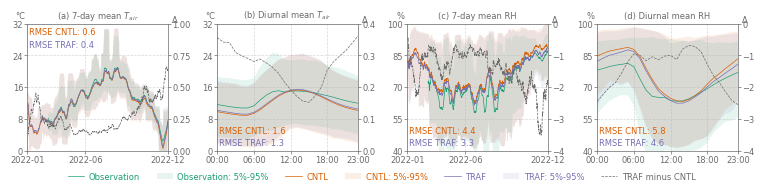

In [5]:
fig, axs = plt.subplots(row, col, figsize=(7.5, 1.75))
ax = axs.flatten()
for i in range(row*col):
    var_index = i // 2
    var_indexed = var_list[var_index]
    ax2 = ax[i].twinx()
    ax_ymin = ax_ymin_list[var_index]
    ax_ymax = ax_ymax_list[var_index]
    ax2_ymin = ax2_ymin_list[i]
    ax2_ymax = ax2_ymax_list[i]
    ax[i].set_ylim([ax_ymin, ax_ymax])
    ax2.set_ylim([ax2_ymin, ax2_ymax])
    ax[i].set_yticks([ax_ymin, ax_ymin + (ax_ymax - ax_ymin)/4, (ax_ymin + ax_ymax)/2, ax_ymax - (ax_ymax - ax_ymin)/4, ax_ymax])
    ax2.set_yticks([ax2_ymin, ax2_ymin + (ax2_ymax - ax2_ymin)/4, (ax2_ymin + ax2_ymax)/2, ax2_ymax - (ax2_ymax - ax2_ymin)/4, ax2_ymax])
    for c, case in enumerate(case_list):
        var = f'{var_indexed}_{case}'
        df_case = df[['time', var]].copy().reset_index()
        df_case['time'] = pd.to_datetime(df_case['time'], format='%Y-%m-%d %H:%M:%S')
        df_case.set_index('time', inplace=True)
        seven_day_mean = df_case[var].rolling(window=336, min_periods=48).mean()
        seven_day_5 = df_case[var].rolling(window=336, min_periods=48).quantile(0.05)
        seven_day_95 = df_case[var].rolling(window=336, min_periods=48).quantile(0.95)
        df_case_diurnal = df[['diurnal', var]].copy()
        diurnal_mean = df_case_diurnal.groupby('diurnal').mean(numeric_only=True)
        diurnal_5 = df_case_diurnal.groupby('diurnal').quantile(0.05)
        diurnal_95 = df_case_diurnal.groupby('diurnal').quantile(0.95)
        if i%2==0:
            ax[i].plot(df_case.index, seven_day_mean.values, label=label_list[c], color=lc[c], linewidth=linewidth)
            ax[i].fill_between(df_case.index, seven_day_5.values, seven_day_95.values, alpha=0.1, color=lc[c],  edgecolor='none', label=label_list[c] + ': 5%-95%')
            xticks = [df['time'].iloc[0]] + mid_time + [df['time'].iloc[-1]]
            #xticks = [df['time'].iloc[0]] + mid_time
            ax[i].set_xticks(xticks)
            ax[i].set_xlim([df.time.iloc[0], df.time.iloc[-1]])
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
        elif i%2==1: 
            ax[i].plot(diurnal_mean.index, diurnal_mean[var], label=label_list[c], color=lc[c], linewidth=linewidth)
            ax[i].fill_between(diurnal_mean.index, diurnal_5[var], diurnal_95[var], alpha=0.1, color=lc[c],  edgecolor='none', label=label_list[c] + ': 5%-95%')
            ax[i].set_xticks([diurnal_mean.index[0], '06:00', '12:00', '18:00', diurnal_mean.index[-1]])
            ax[i].set_xlim([diurnal_mean.index[0], diurnal_mean.index[-1]])
        ax[i].set_title(f'({string.ascii_lowercase[i]}) {metric[i%2]} {sequence2[i//2]}',fontsize=labelfont,color=labelcolor, pad = padding)   
        if i in [0, 1]:
            unit = '°C'
        elif i in [2, 3]:
            unit = '%'        
        ax[i].set_ylabel(unit,labelpad=5, rotation=0, ha='center', fontsize=labelfont,color=labelcolor)
        ax[i].yaxis.set_label_coords(-0.05, 1.025)
        ax[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelcolor=labelcolor, color=labelcolor,labelsize=labelfont,pad=pad, width = xwidth, length = length)
        ax[i].tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=True, labelcolor=labelcolor,color=labelcolor,labelsize=labelfont,pad=pad, width = xwidth, length = length)
        for spine in ax[i].spines.values():
            spine.set_linewidth(xwidth)
            spine.set_edgecolor(labelcolor)       
        ax[i].grid(True,linestyle='--',linewidth=0.5, alpha=0.5)
    df_cntl = df[f'{var_indexed}_cntl']
    df_traf = df[f'{var_indexed}_traffic']
    delta = pd.DataFrame({var_indexed: df_traf.values - df_cntl.values})
    delta['diurnal'] = df_case_diurnal['diurnal']
    delta_index = delta.copy()
    delta_index['time'] = df_case.index
    delta_index.set_index('time', inplace=True)
    delta_senven_day_mean = delta_index[var_indexed].rolling(window=336, min_periods=48).mean()
    delta_diurnal_mean = delta.groupby('diurnal').mean(numeric_only=True)[var_indexed]
    if i%2==0:
       ax2.plot(df_case.index, delta_senven_day_mean.values, label='TRAF minus CNTL', color=labelcolor, linewidth=linewidth, linestyle='--')
    elif i%2==1:
       ax2.plot(diurnal_mean.index, delta_diurnal_mean.values, label='TRAF minus CNTL', color=labelcolor, linewidth=linewidth, linestyle='--')
    for spin in ax2.spines.values():
        spin.set_visible(False)   
    ax2.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelcolor=labelcolor, color=labelcolor,labelsize=labelfont,pad=pad, width = xwidth, length = length)
    ax2.tick_params(axis='x', which='both', top=False, bottom=False, labelbottom=False)   
    ax2.set_ylabel(r'$\Delta$',labelpad=5, rotation=0, ha='center', fontsize=labelfont,color=labelcolor)
    ax2.yaxis.set_label_coords(1.05, 1.085)   
    if i <1:
        yloc = 0.9
    else:
        yloc = 0.125   
    if i%2==0:
        df_var = df[['time', f'{var_indexed}_obs', f'{var_indexed}_cntl', f'{var_indexed}_traffic']].copy()
        df_var = df_var.set_index('time')
        diff_seven_day_mean = df_var.rolling(window=336, min_periods=48).mean()
        diff_traf = rmse(diff_seven_day_mean[f'{var_indexed}_traffic'], diff_seven_day_mean[f'{var_indexed}_obs'])
        diff_cntl = rmse(diff_seven_day_mean[f'{var_indexed}_cntl'], diff_seven_day_mean[f'{var_indexed}_obs'])
        ax[i].text(0.01,yloc,'RMSE CNTL: {:.1f}'.format(diff_cntl.item()), fontsize=labelfont, color=lc[1], horizontalalignment='left', verticalalignment='bottom', transform=ax[i].transAxes)
        ax[i].text(0.01,yloc-0.1,'RMSE TRAF: {:.1f}'.format(diff_traf.item()), fontsize=labelfont, color=lc[2], horizontalalignment='left', verticalalignment='bottom', transform=ax[i].transAxes) 
    elif i%2==1:
        df_var = df[['diurnal', f'{var_indexed}_obs', f'{var_indexed}_cntl', f'{var_indexed}_traffic']].copy()
        diff_diurnal_mean = df_var.groupby('diurnal').mean(numeric_only=True)
        diff_traf = rmse(diff_diurnal_mean[f'{var_indexed}_traffic'], diff_diurnal_mean[f'{var_indexed}_obs'])
        diff_cntl = rmse(diff_diurnal_mean[f'{var_indexed}_cntl'], diff_diurnal_mean[f'{var_indexed}_obs'])
        ax[i].text(0.01,yloc,'RMSE CNTL: {:.1f}'.format(diff_cntl.item()), fontsize=labelfont, color=lc[1], horizontalalignment='left', verticalalignment='bottom', transform=ax[i].transAxes)
        ax[i].text(0.01,yloc-0.1,'RMSE TRAF: {:.1f}'.format(diff_traf.item()), fontsize=labelfont, color=lc[2], horizontalalignment='left', verticalalignment='bottom', transform=ax[i].transAxes)
plt.subplots_adjust(left=0.0275, right=0.975, bottom=0.2, top=0.925, wspace=0.35, hspace= 0.35)
lines1, labels1 = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
legend = fig.legend(lines, labels, bbox_to_anchor=(0.5, -0.015), loc='lower center', frameon=False, 
                        handletextpad=handletextpad, fontsize=labelfont, ncol=8)
for i, text in enumerate(legend.get_texts()):
    text.set_color((lc + [labelcolor] + [labelcolor])[i//2])
#plt.suptitle('Timeseries and diurnal plots for ' + GRIDNAME, fontsize=labelfont+2, color=labelcolor,x=0.5, y=0.99, ha='center', va='top')
fig.savefig(f'{GRIDNAME}.png', dpi=300)    
fig.savefig(f'{GRIDNAME}.pdf', dpi=600)